In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os, sys

In [2]:
from chainer import Chain, ChainList, cuda, gradient_check, Function, Link, optimizers, serializers, utils, Variable, datasets, using_config
from chainer import functions as F
from chainer import links as L

import scipy.special as spsp
class Func_erf2(Function): # (erf(x/sqrt(2)))   
    def forward_cpu(self, x):
        sq2 = x[0].dtype.type(np.sqrt(2.0))
        self.y = utils.force_array(spsp.erf(x[0]/sq2))
        return self.y,
    def backward_cpu(self, x, gy):
        sq2pi = x[0].dtype.type(np.sqrt(2.0/np.pi))
        two = x[0].dtype.type(2.0)
        return utils.force_array(gy[0]*sq2pi*np.exp(-x[0]*x[0]/two)),
def func_erf2(x):
    return Func_erf2()(x)

def is_integer_type(typ):
    try:
        xp = cuda.cupy
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64,
                xp.int8, xp.int16, xp.int32, xp.int64,
                xp.uint8, xp.uint16, xp.uint32, xp.uint64,]
    except AttributeError:
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64]



class MLP(ChainList):
    def __init__(self, ls, nobias, act, opt):
        self.ls = ls
        self.l = []
        for i in range(len(ls)-1):
            self.l.append(L.Linear(ls[i], ls[i+1], nobias=nobias))
        super(MLP, self).__init__(*self.l)
        self.act = act
        self.opt = opt
        if self.opt is not None: self.opt.setup(self)
        self.lossfrac = np.zeros(2)
        self.accfrac = np.zeros(2)
    def __call__(self, x, mode='train'): # Variable受け取ってVariable返す
        with using_config('train', mode=='train'):
            for i in range(len(self.l)):
                x = self.l[i](x)
                if (i+1<len(self.l)): x = self.act(x)
        return x
    def update(self, x, t, mode='train'):  # Variable受け取ってVariable返す
        bs = x.shape[0]
        y = self(x, mode=mode)
        if is_integer_type(t.data.dtype):
            if 1: # 分類 (softmax_cross_entropy)
                loss = F.softmax_cross_entropy(y, t)
                acc = np.count_nonzero(np.argmax(y.data,axis=1)==t.data)
            elif 0: # 二値分類 (sigmoid_cross_entropy)
                loss = F.sigmoid_cross_entropy(y, t) # y and t has same dimension
                acc = np.count_nonzero((y.data>0).astype(np.int32)==t.data)
            else:
                raise ValueError
        else:
            # 回帰 (squared)
            loss = 0.5 * F.sum((y - t)**2) / bs
            acc = 0

        # loss は bs で割られたスカラーになっている．はず
        if mode=='train':
            self.cleargrads()
            loss.grad = np.ones(loss.shape, dtype=np.float32)
            loss.backward()
            self.opt.update()
        elif mode=='test':
            pass
        else:
            raise ValueError
        self.lossfrac += np.array([np.sum(loss.data) * bs, bs])
        self.accfrac += np.array([acc, bs])
        return loss
    def aveloss(self, clear=False):
        ret = self.lossfrac[0]/self.lossfrac[1]
        if clear: self.lossfrac = np.zeros(2)
        return ret
    def aveacc(self, clear=False):
        ret = (0.+self.accfrac[0])/self.accfrac[1]
        if clear: self.accfrac = np.zeros(2)
        return ret
    def W(self, idx):
        return self.l[idx].W.data

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [12]:
# 三層 erf2 パーセプトロンの SGD 学習
N = 1000
eta = 1.0
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.SGD(lr=eta/N))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, 1]], dtype=np.float32)

nb_iter = 20 * N

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]

Ls_sgd = Ls

In [5]:
def average(ary, bin_width):
    return np.array([np.mean(ary[i:i+bin_width]) for i in range(0,len(ary),bin_width)])

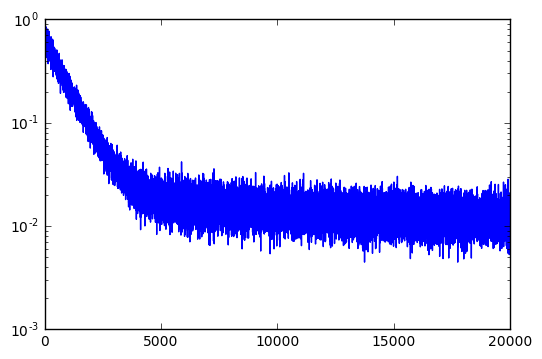

In [13]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()

In [14]:
# 三層 erf2 パーセプトロンの Momentum 学習
N = 1000
eta = 0.1
gamma = 0.9
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.MomentumSGD(lr=eta/N, momentum=gamma))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
nb_iter = 20 * N

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, 1]], dtype=np.float32)

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]

Ls_mom = Ls

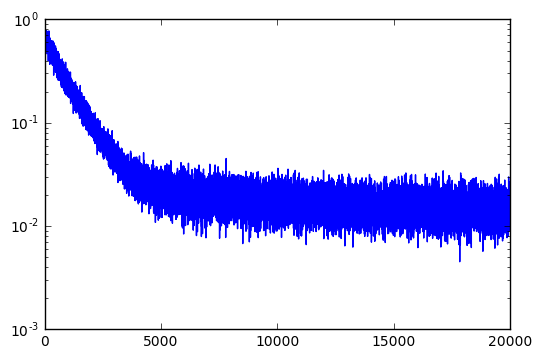

In [15]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()

In [16]:
# 三層 erf2 パーセプトロンの SGD 学習 （第二層の教師を [1,-1] に変えてみた．）
N = 1000
eta = 1.0
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.SGD(lr=eta/N))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, -1]], dtype=np.float32)

nb_iter = 20 * N

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]

Ls_sgd = Ls

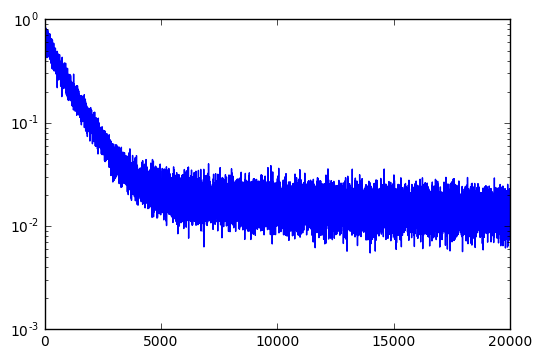

In [17]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()

In [18]:
# 三層 erf2 パーセプトロンの Momentum 学習
N = 1000
eta = 0.1
gamma = 0.9
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.MomentumSGD(lr=eta/N, momentum=gamma))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
nb_iter = 20 * N

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, -1]], dtype=np.float32)

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]

Ls_mom = Ls

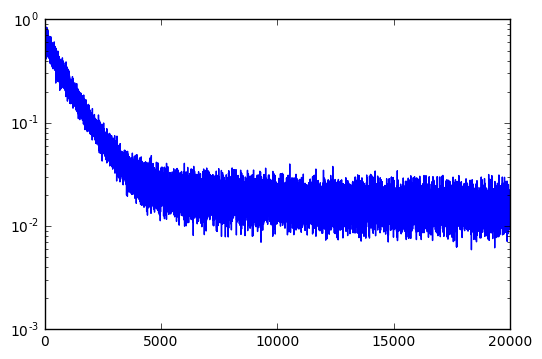

In [19]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()

ひょっとして， 標準ガウス+生徒教師学習　だと，何層積もうとも，モメンタムが「学習係数アップ」と等価になってしまうのでは・・・？

（となると，結局ここでも「標準じゃないガウス入力」を考える価値が出てくる・・・？）

In [22]:
# 三層 erf2 パーセプトロンの SGD 学習 （第二層を[1,1]で「固定」してみると？）
N = 1000
eta = 1.0
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.SGD(lr=eta/N))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, 1]], dtype=np.float32)

nb_iter = 100 * N

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]
    
    mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32) # 第二層の「固定」

Ls_sgd = Ls

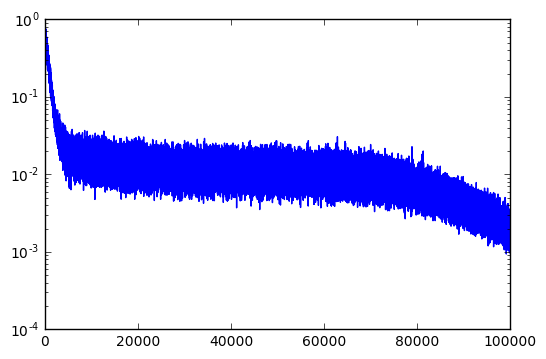

In [23]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()

In [24]:
# 三層 erf2 パーセプトロンの Momentum 学習 （第二層を[1,1]で「固定」してみると？）
N = 1000
eta = 0.1
gamma = 0.9
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.MomentumSGD(lr=eta/N, momentum=gamma))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
nb_iter = 100 * N

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, -1]], dtype=np.float32)

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]
    
    mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32) # 第二層の「固定」

Ls_mom = Ls

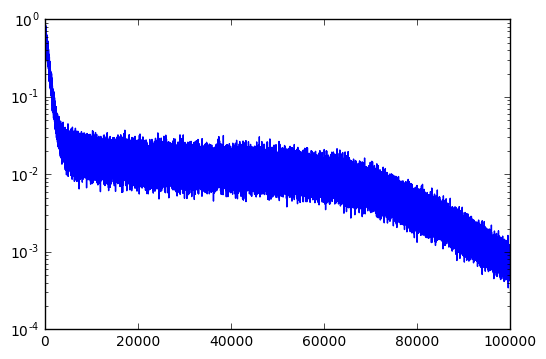

In [25]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()

In [ ]:
# ちょっと早い！！？？いや，気のせいらしい．（次の実験では，逆にモメンタムがちょっと遅い．）

In [26]:
# 三層 erf2 パーセプトロンの SGD 学習 （第二層を[1,1]で「固定」してみると？）（N減らして，もうちょっと長く．）
N = 100
eta = 1.0
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.SGD(lr=eta/N))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, 1]], dtype=np.float32)

nb_iter = 300 * N

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]
    
    mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32) # 第二層の「固定」

Ls_sgd = Ls

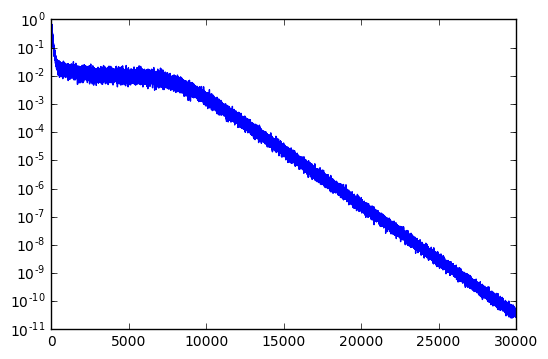

In [27]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()

In [29]:
# 三層 erf2 パーセプトロンの Momentum 学習（第二層を[1,1]で「固定」してみると？）（N減らして，もうちょっと長く．）
N = 100
eta = 0.1
gamma = 0.9
mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.MomentumSGD(lr=eta/N, momentum=gamma))
mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
nb_iter = 300 * N

mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
mdl_t.l[1].W.data = np.array([[1, -1]], dtype=np.float32)

bs = 100

Ls = np.zeros(0)
for it in tqdm(range(nb_iter)):
    xi = Variable(np.random.normal(0, 1, [bs, N]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]
    
    mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32) # 第二層の「固定」

Ls_mom = Ls

23777/|/  8%|| 23777/300000 [03:00<34:51, 132.05it/s]



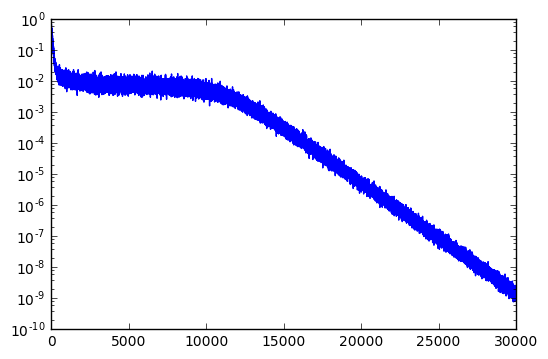

In [30]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.yscale('log')
plt.show()